# Introduction


This Notebook will focus on ML modeling section of uber eats menu price prediction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ahmedshahriar/restaurant-menu-pricing/blob/main/notebooks/uber-eats-EDA.ipynb)    [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ahmedshahriar/restaurant-menu-pricing/blob/main/notebooks/uber-eats-EDA.ipynb)    [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github.com/ahmedshahriar/restaurant-menu-pricing/blob/main/notebooks/uber-eats-EDA.ipynb)


Dataset -

1. Crawled restaurants and menu data: [Uber Eats USA Data](https://www.kaggle.com/datasets/ahmedshahriarsakib/uber-eats-usa-restaurants-menus)
2. Cost of living index data: [Cost of living: bestplaces.net](https://www.bestplaces.net/cost-of-living/)
    - The extracted cost of living index for the shortlisted states/cities is provided in the `extras/data` directory (5 states and 25 cities)
3. Population density: [United States Cities Database](https://www.kaggle.com/datasets/sergejnuss/united-states-cities-database) [population density feature might not contribute much to the model, however further analysis required]

> To capture how price can vary with location I looked at various socio-economic factors i.e., population density & cost of living in the USA. The United States cities database is from 2022 and contains the population density metric alongside `city` & `state id`. Using the population density data set, I shortlisted 5 state-city combinations i.e.25 cities in total. Moreover, since I could not find any publicly available data for cost of living which covers all the cities of my restaurant dataset, I extracted the cost of living index for the shortlisted cities and were able to successfully get information for 25 cities

Other datasource - 

[State Abbreviations](https://www.kaggle.com/datasets/doyouevendata/state-abbreviations)

This notebook will generate two datasets - 
1. With ingredients list
2. With ingredients embeddings

# Libraries

In [1]:
# !pip install -q --upgrade accelerate  --quiet

# track the issue
# https://github.com/huggingface/transformers/issues/23340

# ! pip install -U git+https://github.com/huggingface/transformers.git
# ! pip install -U git+https://github.com/huggingface/accelerate.git

# !pip install -U transformers --quiet

In [143]:
import html
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from transformers import AutoModelForTokenClassification, AutoTokenizer, BertModel, BertTokenizer, pipeline

torch.set_num_threads(2)
tqdm.pandas()

pd.set_option("display.width", None)
pd.set_option("max_colwidth", None)


warnings.filterwarnings("ignore", category=DeprecationWarning)

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["figure.dpi"] = 150

SEED = 33


os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Ignore FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# experiment parallelization
# !pip install pandarallel --quiet

# from pandarallel import pandarallel

# pandarallel.initialize(progress_bar=True)

In [5]:
sns.set_style("whitegrid")  # whitegrid
sns.set_theme(style="white")

# size=25
size = 15
params = {
    "legend.fontsize": "large",
    "figure.figsize": (10, 8),
    "figure.dpi": 150,
    "axes.labelsize": size,
    "axes.titlesize": size,
    "xtick.labelsize": size * 0.75,
    "ytick.labelsize": size * 0.75,
    "axes.titlepad": 25,
}
plt.rcParams.update(params)

In [ ]:
%%time

# zip code varies in states, hence removed, we can get location from coordinates or full address
# search position doesn't give any context in price prediction, hence removed
# name is removed as it's not helpful in price prediction
res_cols = ["id", "score", "ratings", "category", "price_range", "full_address", "lat", "lng"]

df_restaurant = pd.read_csv(
    "datasets/restaurants.csv",
    skipinitialspace=True,
    usecols=res_cols,
    converters={
        "id": np.int32,
        "position": np.int32,
        #                                                           'score': lambda x: np.float32(x) if x != None else np.nan,
        #                                                           'score':np.float32, 'ratings':np.float32,
        "lat": np.float32,
        "lng": np.float32,
    },
)


# Specify the columns to unescape
columns_to_unescape = ["name", "category", "description"]


# Define the converter function
def unescape_html(value):
    if pd.notnull(value):
        return html.unescape(value)
    return value


# Define the converters dictionary
# converters_menu = {'restaurant_id': np.int32}
# for col in columns_to_unescape:
#     converters_menu[col] = unescape_html


df_menu = pd.read_csv("dataset/restaurant-menus.csv", skipinitialspace=True)

# https://www.kaggle.com/datasets/kkhandekar/cost-of-living-index-by-city-2022
df_index = pd.read_csv(
    "dataset/costofliving.csv",
    skipinitialspace=True,
)

# https://www.kaggle.com/datasets/sergejnuss/united-states-cities-database
df_density = pd.read_csv(
    "dataset/uscities.csv",
    skipinitialspace=True,
)


print(f"Menu Dim: {df_menu.shape}, Restaurant Dim: {df_restaurant.shape}")

print("Check Missing Vlaues on Menu Data")
print(df_menu.isna().sum())

# in linux default int is int64 whereas in windows it's int64
# https://github.com/unionai-oss/pandera/issues/726

# skipinitialspace to trim whitespace
# https://stackoverflow.com/a/43332157/11105356

In [ ]:
%%time

# strip description
df_menu["description"] = df_menu.description.str.strip()
df_menu.dropna(subset=["description"], inplace=True)

df_menu["category"] = df_menu.category.map(unescape_html).copy()
df_menu["category"] = df_menu.category.str.strip().str.normalize("NFKD").copy()

df_menu["description"] = df_menu.description.map(unescape_html).copy()
df_menu["description"] = df_menu.description.str.strip().str.normalize("NFKD").copy()

df_menu.drop(df_menu[df_menu.description.str.len() == 0].index, inplace=True)


print("Menu Data Summary")
print(df_menu.info())

print("Restaurant Data Summary")
print(df_restaurant.info())


# check for duplicates
print(
    f"Restaurant Duplicates Dim: {df_restaurant[df_restaurant.duplicated()].shape}, Menu Duplicates Dim: {df_menu[df_menu.duplicated()].shape}"
)

# drop duplicates rows from menu
df_menu.drop_duplicates(inplace=True)


### convert price to float
# df_menu[df_menu.price.str.contains("$")].shape[0] # total 2414321
# price_parse_regex = r'[\d]+[.,\d]+|[\d]*[.][\d]+|[\d]+'
# price_parse_regex = r'(\d+.\d+)'

print("Price distribution")

df_menu.price.str.len().value_counts()

df_menu["price"] = df_menu["price"].replace({"USD": ""}, regex=True).astype("float").copy()
# df_menu.price.astype('str').str.strip().str.len().value_counts()
# df_menu[(df_menu.price.str.len() == 9) & (df_menu.price.str.endswith('0'))]

# drop rows having 0 price
df_menu = df_menu[df_menu["price"] != 0].copy()


# check restaurant with no menu description
no_menu_res_list = set(df_restaurant.id.unique()) - set(df_menu.restaurant_id.unique())
print("Restaurant with no menu", len(no_menu_res_list))


# drop restaurant with no menu description
df_restaurant.drop(df_restaurant.index[df_restaurant["id"].isin(no_menu_res_list)], inplace=True)


# drop restaurant with no price_range
df_restaurant.dropna(subset=["price_range"], inplace=True)


# drop restaurants with missing full address
df_restaurant.dropna(subset=["full_address"], inplace=True)


no_res_menu_list = set(df_menu.restaurant_id.unique()) - set(df_restaurant.id.unique())
print("Menu with no restaurant", len(no_res_menu_list))


# drop restaurants from menu df with missing restaurant feature
df_menu.drop(df_menu.index[df_menu["restaurant_id"].isin(no_res_menu_list)], inplace=True)


df_menu = df_menu[df_menu.category != "Picked for you"].copy()

print("Restaurant Missing values")
print(df_restaurant.isna().sum())


# any restaurant or menu id missing in both df?
print("Any restaurant or menu id missing in both df?")
(
    len(set(df_menu.restaurant_id.unique()) - set(df_restaurant.id.unique())),
    len(set(df_restaurant.id.unique()) - set(df_menu.restaurant_id.unique())),
)

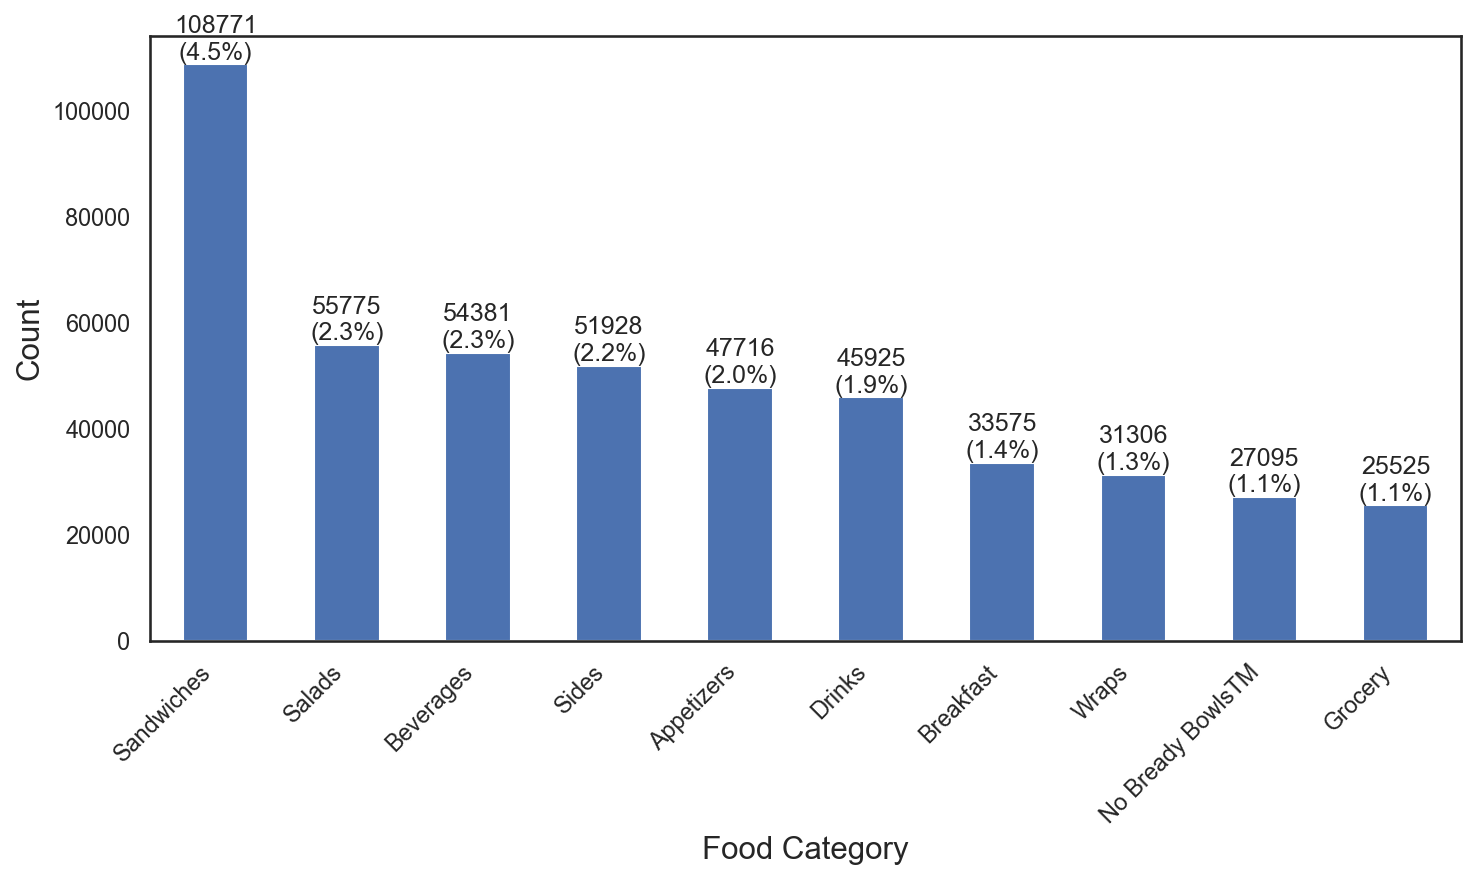

In [16]:
plt.figure(figsize=(10, 6))
ax = df_menu.category.value_counts().head(10).plot(kind="bar")
plt.xlabel("Food Category")
plt.ylabel("Count")
# plt.title('State Count')
plt.xticks(rotation=45, ha="right")

for p in ax.patches:
    count = p.get_height()
    percentage = 100 * count / df_menu.shape[0]  # Total number of data points in the DataFrame
    ax.annotate(
        f"{count}\n({percentage:.1f}%)",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
    )

# Show the plot
plt.tight_layout()
plt.show()

# Address Mapping

In [17]:
df_restaurant.full_address.str.split(",").apply(len).value_counts()

# address with states
df_restaurant = df_restaurant[df_restaurant.full_address.str.split(",").apply(lambda x: len(x[-2].strip())) == 2].copy()
# df_restaurant.shape

res_cities = set(df_restaurant.full_address.str.split(",").apply(lambda x: x[-3].strip().lower()).tolist())
print("cities", len(res_cities))

cities 1406


### Population Index Data

In [27]:
# df_restaurant_state[df_restaurant_state.full_address.str.split(',').apply(lambda x: len(x[-3].strip())) <4]
# df_index[df_index.City.str.contains("States")].City.str.split(",").apply(len).value_counts()

df_index[df_index.City.str.contains("States")].City.str.split(",").apply(lambda x: x[-2]).value_counts()

index_cities = set(
    df_index[df_index.City.str.contains("States")].City.str.split(",").apply(lambda x: x[-3].strip().lower()).tolist()
)

len(res_cities.intersection(index_cities))

30

### Population Density Data

In [18]:
# check cities from the density data
density_cities = set(df_density.city.str.strip().str.lower())

# primary city list proposal
proposed_cities = res_cities.intersection(density_cities)

# filter restaurant with proposed cities
df_restaurant = df_restaurant[df_restaurant.full_address.str.lower().str.contains("|".join(proposed_cities))].copy()


df_restaurant_filtered = df_restaurant.copy()

# filter missing cities
null_city_filter = (
    df_restaurant_filtered.full_address.str.strip().str.lower().str.split(",").apply(lambda x: len(x[-3])) != 0
)
df_restaurant_filtered = df_restaurant_filtered[null_city_filter].copy()
df_restaurant_filtered["city"] = df_restaurant.full_address.str.strip().str.lower().str.split(",").str[-3].str.strip()
df_restaurant_filtered["state_id"] = (
    df_restaurant.full_address.str.strip().str.lower().str.split(",").str[-2].str.strip()
)

# merge data based on the most occurred states
# state id in lowercase: 'tx', 'va', 'wa', 'wi', 'ut'

temp_df = df_density[["city", "density", "state_id"]].apply(lambda x: x.astype(str).str.lower().str.strip())
df_res_density = pd.merge(df_restaurant_filtered, temp_df, how="left", on=["city", "state_id"]).copy()
df_res_density.dropna(subset=["density"], inplace=True)
df_res_density["density"] = df_res_density.density.astype("int32")
del temp_df

df_res_density.groupby(["state_id"])["city"].agg(["count"]).reset_index().sort_values(ascending=False, by="count")
df_top_state = df_res_density[df_res_density.state_id.isin(["tx", "va", "wa", "wi", "ut"])].copy()
# df_top_state.to_csv("top-5-state-data.csv", index=False)

In [19]:
# state distribution
df_res_density.state_id.value_counts()

state_id
tx    13041
va     6974
wa     6911
wi     3597
ut     2310
wv     1192
dc     1017
al      903
or      674
md      662
wy      291
il      176
vt      117
tn       38
mn       37
id       22
pr       19
ar       19
oh       15
Name: count, dtype: int64

In [20]:
df_res_density.state_id.value_counts().head(5)

state_id
tx    13041
va     6974
wa     6911
wi     3597
ut     2310
Name: count, dtype: int64

### Top States

In [22]:
df_states = pd.read_csv(
    "dataset/state_abbrev.csv",
    skipinitialspace=True,
)
df_states.drop(columns=["Unnamed: 2"], axis=1, inplace=True)
df_states.Abbreviation = df_states.Abbreviation.map(str.lower)
states_name_dict = df_states.set_index("Abbreviation")["State"].to_dict()

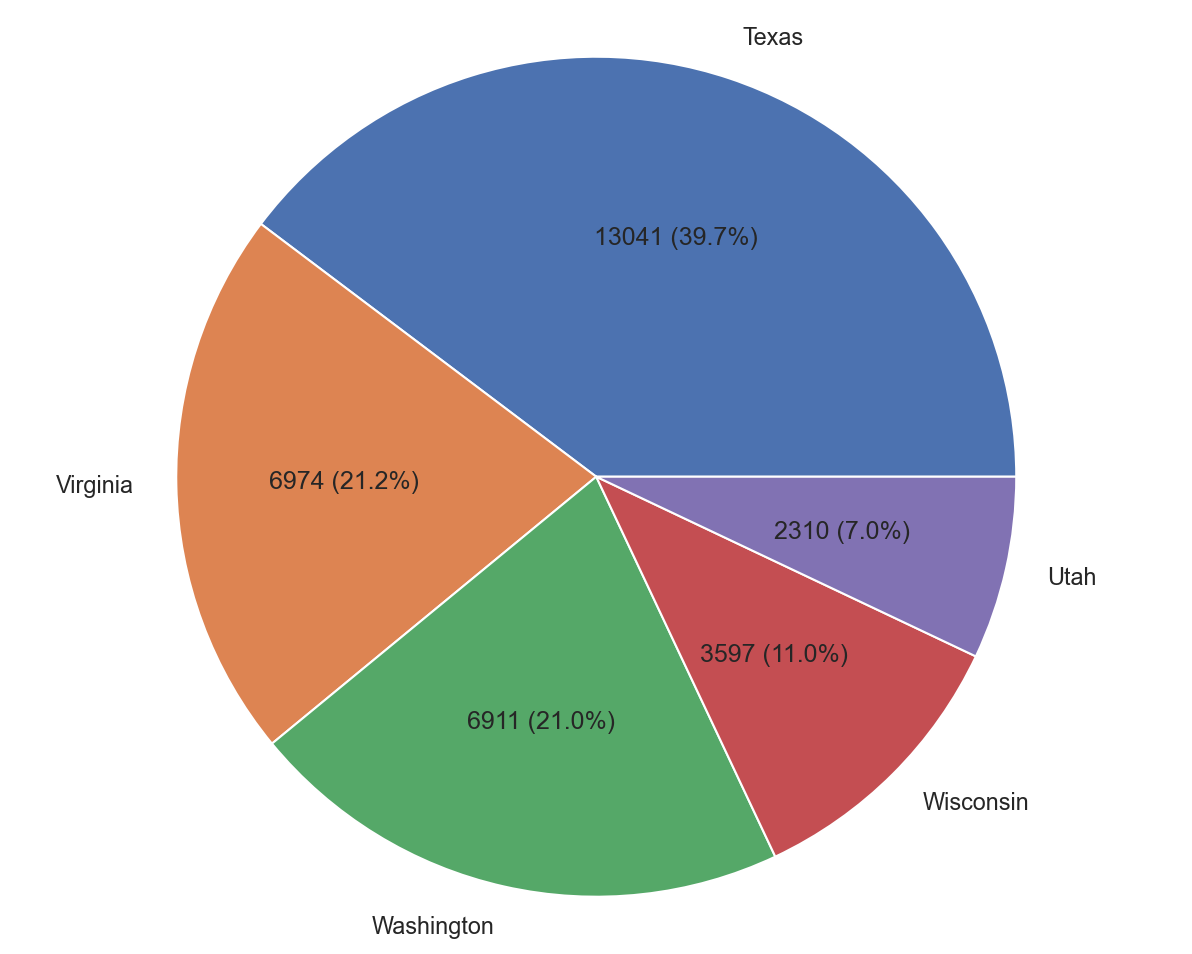

In [23]:
# https://matplotlib.org/3.1.0/gallery/pie_and_polar_charts/pie_and_donut_labels.html

df_top_5_states = df_res_density.state_id.value_counts().head(5)

df_top_5_states.rename(index=states_name_dict, inplace=True)

# plt.figure(figsize=(8, 8))

plt.pie(
    df_top_5_states, labels=df_top_5_states.index, autopct=lambda p: f"{p * df_top_5_states.sum() / 100:.0f} ({p:.1f}%)"
)
# plt.title('Top States by Count')
# plt.legend(df_top_5_states.index, loc='best')
plt.axis("equal")
plt.show()

# Sampling

## Top Category

In [24]:
# merge menu and top 5 state data
df_res_ext = pd.merge(
    df_menu[["restaurant_id", "category"]], df_top_state, left_on="restaurant_id", right_on="id", how="left"
).copy()

df_res_ext.rename(columns={"category_x": "menu_category", "category_y": "restaurant_category"}, inplace=True)
df_res_ext.drop(["id"], axis=1, inplace=True)

In [25]:
# Find top categoriers based on top states and cities
category_counts = df_res_ext.groupby(["state_id", "city", "menu_category"]).size().reset_index(name="count")
sorted_categories = category_counts.sort_values("count", ascending=False)

# top 15 categories
top_categories = sorted_categories.groupby(["state_id", "city"]).head(15)

top_categories

,state_id,city,menu_category,count
40462,tx,san antonio,Sandwiches,2152
38211,tx,san antonio,Appetizers,2017
134020,wi,milwaukee,Sandwiches,1894
5085,tx,austin,Sandwiches,1765
5211,tx,austin,Sides,1700
...,...,...,...,...
84243,va,pulaski,Dessert,1
132351,wi,markesan,Entrees,1
132358,wi,marshall,Pizza,1
108294,wa,mead,Shareables,1


In [26]:
# top category distribution
top_categories.menu_category.value_counts()

menu_category
Salads               520
Sandwiches           509
Sides                470
Drinks               455
Beverages            375
Appetizers           364
Wraps                357
Breakfast            314
No Bready BowlsTM    305
Grocery              244
Name: count, dtype: int64

In [28]:
# Unique category distribution by states

top_categories.groupby(["state_id"]).city.nunique()

# top_categories.to_csv("top-15-categories.csv", index=False)

state_id
tx    254
ut     88
va    173
wa    140
wi    234
Name: city, dtype: int64

## Merge Menu and Restaurnant Data

In [29]:
# top_categories.state_id.nunique()

cat_list = ["Sandwiches", "Salads", "Wraps"]

# top_categories[top_categories.menu_category.isin(cat_list)].to_csv("top-3-categories.csv", index=False)
top_filtered_categories = top_categories[top_categories.menu_category.isin(cat_list)].copy()

# Group the data by 'state_id' and 'city' and sum the counts for each city in each state
state_city_counts = top_filtered_categories.groupby(["state_id", "city"])["count"].sum().reset_index()

# Sort the cities within each state based on the aggregated count in descending order
state_city_counts = state_city_counts.sort_values(["state_id", "count"], ascending=[True, False])

# Get the top 5 cities for each state
top_10_cities = state_city_counts.groupby("state_id").head(5)

# Print the top 10 cities based on aggregated count in each state
# top_10_cities.to_csv('top-cities-filtered-categories.csv')

df_res_ext.dropna(subset=["price_range"], inplace=True)

In [181]:
top_10_cities[["count"]].apply(lambda x: x.sum())
top_10_cities[top_10_cities.state_id == "tx"][["count"]].apply(sum)

count    12568
dtype: int64

In [30]:
# merge top 10 cities data with restaurant data
res_filtered_df = pd.merge(df_res_ext, top_10_cities[["state_id", "city"]], on=["state_id", "city"]).copy()

In [31]:
res_filtered_df.drop_duplicates(inplace=True)

print("Filter menu category in filtered restaurant dataset")
res_filtered_df[res_filtered_df.menu_category.isin(cat_list)].shape

Filter menu category in filtered restaurant dataset


(3413, 12)

In [32]:
df_final = pd.merge(
    res_filtered_df[["restaurant_id", "price_range", "state_id", "city", "density"]],
    df_menu[["restaurant_id", "category", "description", "price"]],
    on=["restaurant_id"],
).copy()

df_final = df_final[df_final.category.isin(cat_list)].copy()
df_final.drop_duplicates(inplace=True)

In [33]:
# state, city count
df_final.state_id.nunique(), df_final.city.nunique()

(5, 25)

In [36]:
# price distribution
df_final[["price"]].describe().T
# df_final.to_csv("recipe-all-3-category.csv", index=False)

,count,mean,std,min,25%,50%,75%,max
price,44183.0,10.792378,4.567102,0.25,8.39,10.1,12.69,138.6


# Feature Engineering

In [37]:
# Unique Menu
df_menu.category.nunique()

37282

In [38]:
# Menu distribution
df_menu.category.value_counts().head(30)

category
Sandwiches           108771
Salads                55775
Beverages             54381
Sides                 51928
Appetizers            47716
Drinks                45925
Breakfast             33575
Wraps                 31306
No Bready BowlsTM     27095
Grocery               25525
Personal Care         24303
Desserts              19666
Fresh Melts®          18856
Burgers               17800
Combos                17030
Bakery                16815
Snacks                16020
Household             15169
Entrees               15073
Beauty                15036
Pizza                 12662
Candy                 12576
Seafood               11420
Chicken               11201
Mains                 11080
Burritos              10439
Ice Cream             10337
Snacks & Sweets       10272
Cold Coffees          10217
Hot Coffees           10012
Name: count, dtype: int64

## Sandwich Menu description

In [39]:
%%time

cat_filter = df_menu.category == "Sandwiches"
delim_filter = df_menu.description.str.contains(",")
delim_count_filter = df_menu.description.str.count(",")

df_menu[cat_filter].description.head()

CPU times: user 1.99 s, sys: 424 ms, total: 2.41 s
Wall time: 2.47 s


421                                                                                                                                                     Two batter dipped fish fillets on a toasty bun with cracklins, tangy tartar sauce, and shredded lettuce
552                                                                                      560 Cal. Seasoned and seared chicken breast, parmesan crisps, emerald greens and garlic aioli on a brioche roll. Allergens: Contains Wheat, Milk, Egg. May contain Soy
553                                                                            570 Cal. Seasoned and seared chicken breast, spicy Buffalo sauce, crispy pickle chips, and garlic aioli on a brioche roll. Allergens: Contains Wheat, Milk, Egg. May contain Soy
554    Whole (830 Cal.), Half (420 Cal.) Smoked, pulled chicken raised without antibiotics, fresh mozzarella, salt and pepper, vine-ripened tomatoes, red onions, fresh basil and chipotle sauce on Black Pepper Focaccia. Allergens: Co

In [40]:
df_menu[cat_filter & delim_filter].description.head()

421                                                                                                                                                     Two batter dipped fish fillets on a toasty bun with cracklins, tangy tartar sauce, and shredded lettuce
552                                                                                      560 Cal. Seasoned and seared chicken breast, parmesan crisps, emerald greens and garlic aioli on a brioche roll. Allergens: Contains Wheat, Milk, Egg. May contain Soy
553                                                                            570 Cal. Seasoned and seared chicken breast, spicy Buffalo sauce, crispy pickle chips, and garlic aioli on a brioche roll. Allergens: Contains Wheat, Milk, Egg. May contain Soy
554    Whole (830 Cal.), Half (420 Cal.) Smoked, pulled chicken raised without antibiotics, fresh mozzarella, salt and pepper, vine-ripened tomatoes, red onions, fresh basil and chipotle sauce on Black Pepper Focaccia. Allergens: Co

In [41]:
df_menu[cat_filter & (delim_count_filter > 3)].tail(10)

,restaurant_id,category,name,description,price
4094507,50207,Sandwiches,"Steak ""Cali Fresh"" Footlong Regular Sub","The Cali Steak is a hit in any time zone, made on our freshly baked Hearty Multigrain bread with delicious steak, hickory smoked bacon, smashed avocado, BelGioioso® Fresh Mozzarella and fresh veggies of your choice.",14.19
4094508,50207,Sandwiches,"Steak ""Cali Fresh"" Footlong Pro (Double Protein)","The Cali Steak is a hit in any time zone, made on our freshly baked Hearty Multigrain bread with delicious steak, hickory smoked bacon, smashed avocado, BelGioioso® Fresh Mozzarella and fresh veggies of your choice.",17.89
4094521,50207,Sandwiches,Veggie Delite® 6 Inch Regular Sub,"The Veggie Delite® sandwich is crispy, crunchy, vegetarian perfection. With lettuce, baby spinach, tomatoes, cucumbers, green peppers and red onions, all on our Hearty Multigrain bread.",4.99
4094522,50207,Sandwiches,Veggie Delite® Footlong Regular Sub,"The Veggie Delite® sandwich is crispy, crunchy, vegetarian perfection. With lettuce, baby spinach, tomatoes, cucumbers, green peppers and red onions, all on our Hearty Multigrain bread.",7.59
4094523,50207,Sandwiches,Veggie Patty 6 Inch Regular Sub,"Delicious vegan patties with lettuce, tomatoes, cucumbers, green peppers and red onions, all served on our freshly baked Hearty Multigrain bread.",6.19
4094524,50207,Sandwiches,Veggie Patty Footlong Regular Sub,"Delicious vegan patties with lettuce, tomatoes, cucumbers, green peppers and red onions, all served on our freshly baked Hearty Multigrain bread.",9.49
4094525,50207,Sandwiches,Veggie Patty Footlong Pro (Double Protein),"Delicious vegan patties with lettuce, tomatoes, cucumbers, green peppers and red onions, all served on our freshly baked Hearty Multigrain bread.",12.99
4096260,50226,Sandwiches,Bella Sandwich,"Grilled Portabella Mushrooms Topped with: Swiss Cheese, Lettuce, Tomato, Pickles, Onions.\r\nServed on a White Brioche Bun",12.02
4096261,50226,Sandwiches,Chicken Sandwich,"Perfectly Seasoned Grilled Chicken Breast. Topped with: Swiss Cheese, Mayo, Lettuce, Tomato, Pickles, Onions.\r\nServed on a White Brioche Bun",14.15
4096263,50226,Sandwiches,Club,"Deli Ham & Turkey. Topped with: Cheddar & Pepper-Jack Cheese, Lettuce, Tomato, Applewood Smoked Bacon, Mayo and a side of Honey Mustard. \r\nServed on Wheat Toast",12.05


<Axes: >

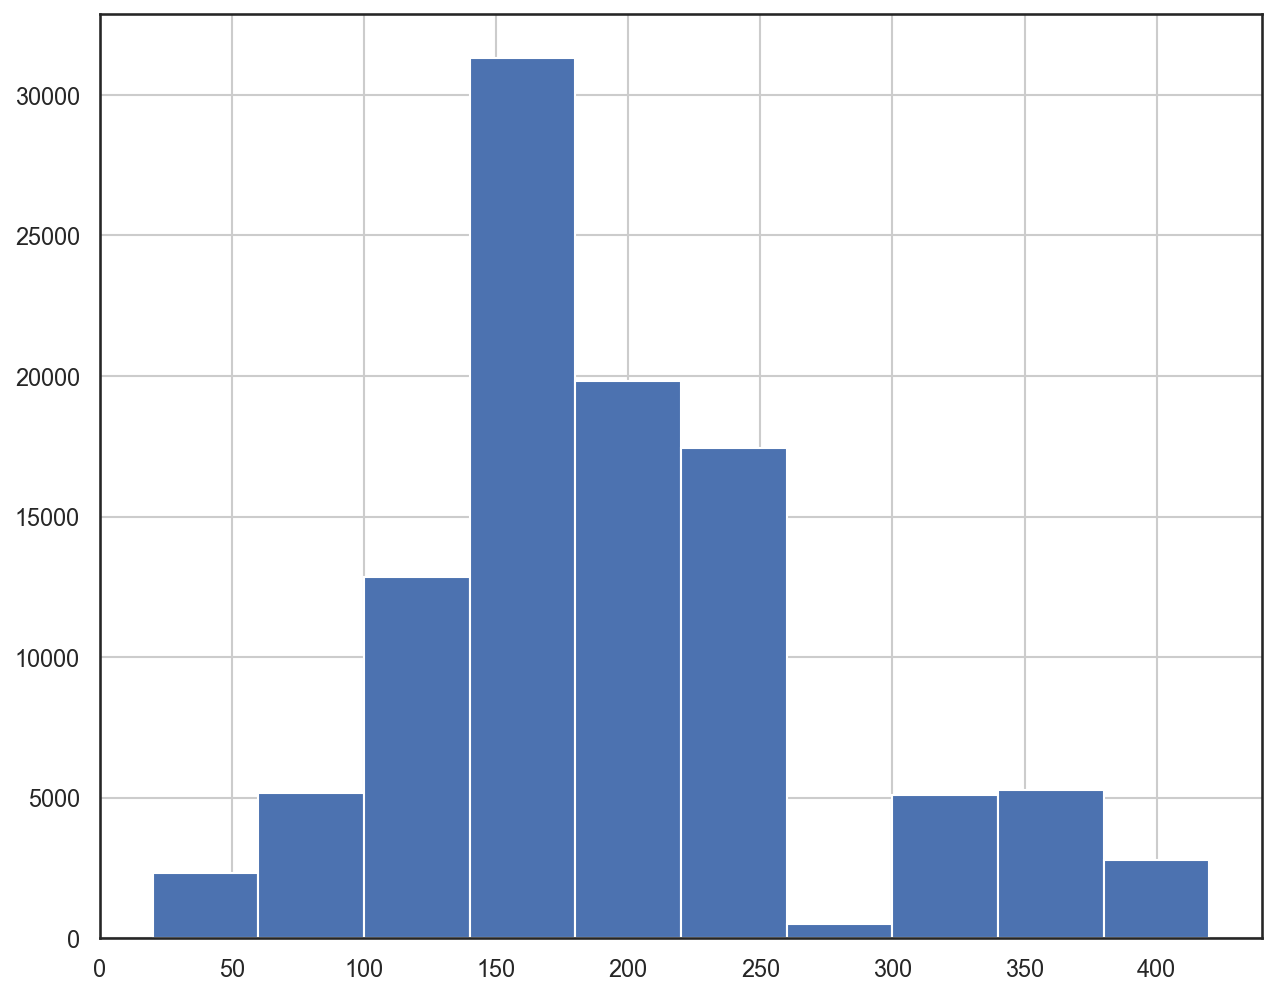

In [42]:
# histogram for character count of the description from the category sandwich and if it contains ','

df_menu[cat_filter][df_menu[cat_filter].description.str.contains(",")].description.apply(lambda x: len(x)).hist()

In [44]:
df_menu[(df_menu.category == "Sides")][
    df_menu[(df_menu.category == "Sides")].description.str.contains(",")
].description.head()

440                                                       A perfectly baked potato, loaded with cheese and bacon.
445                A simple, southern classic; slices of okra in southern-style breading fried to a golden brown.
892                                                                                   Served with Cucumber, Mint.
918                      Crinkle fries seasoned with spicy red pepper, garlic, paprika, sugar, and a hint of lime
919    Seasoned crinkle fries loaded with caramelized onions, American cheese, pickles, mayo, ketchup and mustard
Name: description, dtype: object

<Axes: >

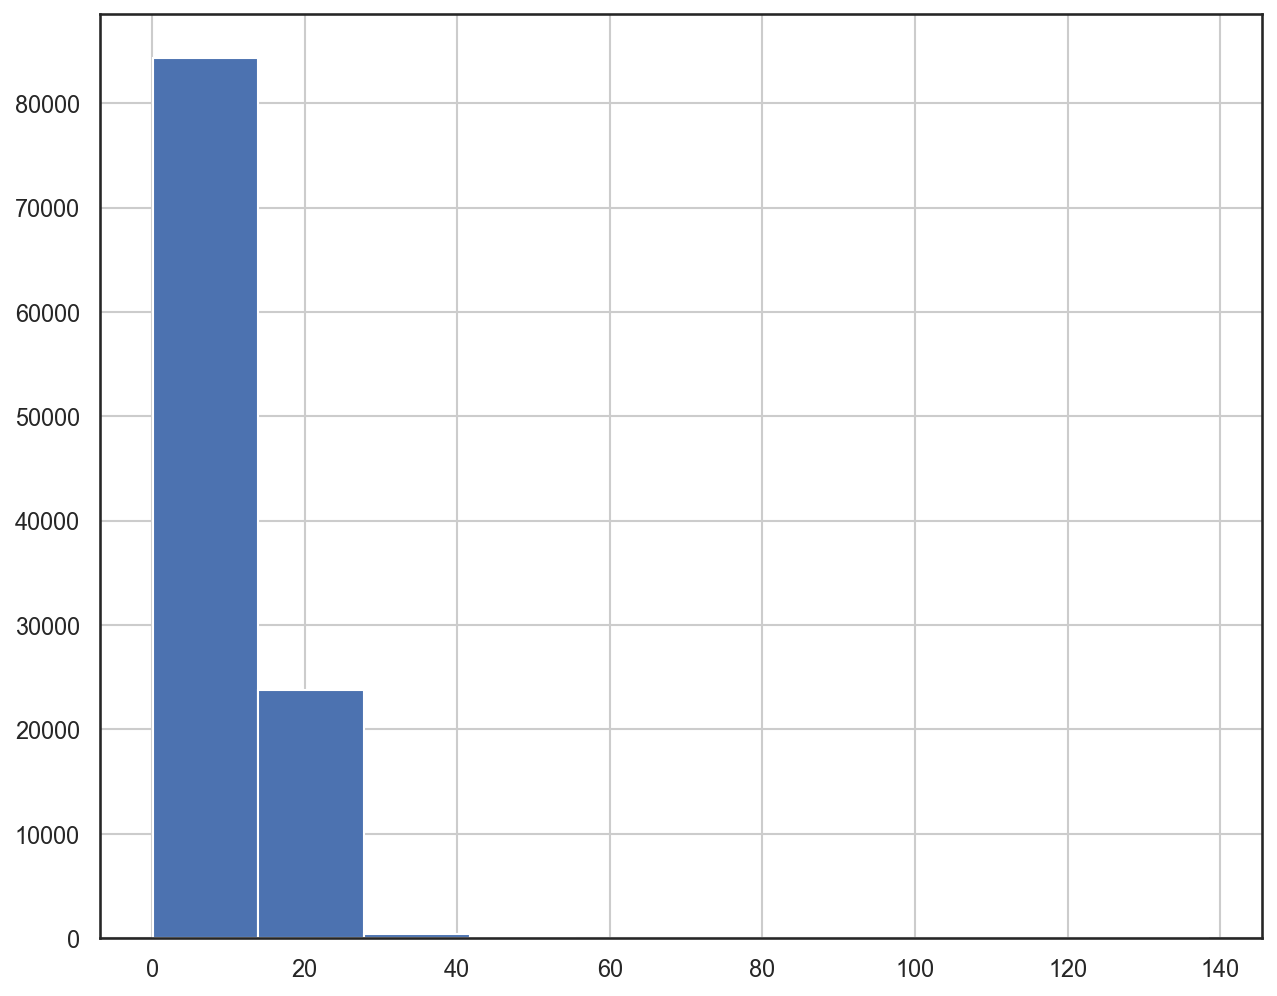

In [45]:
df_menu[df_menu.category == "Sandwiches"].price.hist()
# df_menu[df_menu.category == 'Appetizers'].price.hist()
# df_menu[df_menu.category == 'Wraps'].price.hist()

## Ingredients Extraction

In [47]:
# check mps
torch.backends.mps.is_available(), torch.backends.mps.is_built()

(True, True)

In [50]:
"cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

'mps'

### Candidate NER Models

In [126]:
# search space
# https://huggingface.co/models?search=food
# https://huggingface.co/models?search=recipe

# try out this example
# A fried chicken breast with lettuce, tomato, bacon, Swiss cheese, and ranch dressing on a white bun. Served with your choice of one side.

# """selected models"""

# https://huggingface.co/Dizex/FoodBaseBERT-NER
# https://huggingface.co/Dizex/InstaFoodRoBERTa-NER

# other candidate models

# https://huggingface.co/davanstrien/deberta-v3-base_fine_tuned_food_ner # mislabeled food
# https://huggingface.co/edwardjross/xlm-roberta-base-finetuned-recipe-all # small tokens, works well with short text
# https://huggingface.co/chambliss/distilbert-for-food-extraction # labeling issue


# tokenizer = AutoTokenizer.from_pretrained("edwardjross/xlm-roberta-base-finetuned-recipe-all")
# model = AutoModelForTokenClassification.from_pretrained("edwardjross/xlm-roberta-base-finetuned-recipe-all")


# tokenizer = AutoTokenizer.from_pretrained("davanstrien/deberta-v3-base_fine_tuned_food_ner")
# model = AutoModelForTokenClassification.from_pretrained("davanstrien/deberta-v3-base_fine_tuned_food_ner")


# tokenizer = AutoTokenizer.from_pretrained("Dizex/FoodBaseBERT-NER")
# model = AutoModelForTokenClassification.from_pretrained("Dizex/FoodBaseBERT-NER")
# os.environ['CUDA_VISIBLE_DEVICES'] ='0'
device = "cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("Dizex/InstaFoodRoBERTa-NER")
model = AutoModelForTokenClassification.from_pretrained("Dizex/InstaFoodRoBERTa-NER").to(device)

pipe = pipeline("ner", model=model, tokenizer=tokenizer, device=device)  # 0 if cuda is enable or device

#### Utility

In [135]:
text1 = "A fried chicken breast with lettuce, tomato, bacon, Swiss cheese, and ranch dressing on a white bun. Served with your choice of one side."
text2 = "Filled with hummus, tahini sauce, lettuce, tomatoes, pickles, and come with fries."

text_list = [text1, text2]
ner_entity_results = pipe(text_list, aggregation_strategy="simple")
print("NER Example Results Dict\n", ner_entity_results)


def convert_entities_to_list(text, entities: list[dict]) -> list[str]:
    ents = []
    for ent in entities:
        e = {"start": ent["start"], "end": ent["end"], "label": ent["entity_group"]}
        if ents and -1 <= ent["start"] - ents[-1]["end"] <= 1 and ents[-1]["label"] == e["label"]:
            ents[-1]["end"] = e["end"]
            continue
        ents.append(e)

    return [text[e["start"] : e["end"]] for e in ents]


for txt, tokens in zip(text_list, ner_entity_results, strict=False):
    print("Ingredient Lists:", convert_entities_to_list(txt, tokens))


def get_ingredient_tokens(menu_description):
    ner_entity_result = pipe(menu_description, aggregation_strategy="simple")
    return convert_entities_to_list(menu_description, ner_entity_result)

NER Example Results Dict
 [[{'entity_group': 'FOOD', 'score': 0.9998406, 'word': ' chicken breast', 'start': 8, 'end': 22}, {'entity_group': 'FOOD', 'score': 0.99985194, 'word': ' lettuce', 'start': 28, 'end': 35}, {'entity_group': 'FOOD', 'score': 0.99988985, 'word': ' tomato', 'start': 37, 'end': 43}, {'entity_group': 'FOOD', 'score': 0.99987936, 'word': ' bacon', 'start': 45, 'end': 50}, {'entity_group': 'FOOD', 'score': 0.9997053, 'word': ' Swiss cheese', 'start': 52, 'end': 64}, {'entity_group': 'FOOD', 'score': 0.9996019, 'word': ' ranch dressing', 'start': 70, 'end': 84}, {'entity_group': 'FOOD', 'score': 0.7255845, 'word': ' bun', 'start': 96, 'end': 99}], [{'entity_group': 'FOOD', 'score': 0.9999311, 'word': ' hum', 'start': 12, 'end': 15}, {'entity_group': 'FOOD', 'score': 0.9999287, 'word': 'mus', 'start': 15, 'end': 18}, {'entity_group': 'FOOD', 'score': 0.99991786, 'word': ' t', 'start': 20, 'end': 21}, {'entity_group': 'FOOD', 'score': 0.99993837, 'word': 'ah', 'start': 2

In [73]:
%%time

df_menu[cat_filter & delim_filter].description.head().apply(get_ingredient_tokens)

CPU times: user 344 ms, sys: 323 ms, total: 667 ms
Wall time: 1.36 s


421                                                                        [fish fillets, bun, cracklins, tartar sauce, lettuce]
552                         [chicken breast, parmesan crisps, emerald greens, garlic aioli, brioche roll, Wheat, Milk, Egg, Soy]
553                             [chicken breast, Buffalo sauce, pickle chips, garlic aioli, brioche roll, Wheat, Milk, Egg, Soy]
554    [chicken, mozzarella, salt, pepper, tomatoes, red onions, basil, chipotle sauce, Black Pepper Focaccia, Wheat, Milk, Egg]
555             [chicken, Gouda, avocado, cilantro, PeppadewTM peppers, chipotle sauce, Black Pepper Focaccia, Wheat, Milk, Egg]
Name: description, dtype: object

In [75]:
# !nvidia-smi
# torch.cuda.is_available()
"cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

'mps'

## Random Sample Menu

In [76]:
%%time

# cat_list = ['Sandwiches', 'Wraps', 'Appetizers']
# df_menu_category = df_menu[(df_menu.category.isin(cat_list)) & delim_filter].copy()


# take a sample of 3 categories with 1000 datapoints each
# df_sampled = df_final.groupby('category', group_keys=False).apply(lambda x: x.sample(1000, random_state=SEED))

df_sampled = df_final.copy()
# df_menu[cat_filter & delim_filter].description.head()

CPU times: user 4.63 ms, sys: 38.4 ms, total: 43 ms
Wall time: 86.8 ms


In [77]:
df_sampled.shape

(44183, 8)

In [79]:
df_sampled[["price"]].describe().T.style.format("{:.6}")

,count,mean,std,min,25%,50%,75%,max
price,44183.0,10.7924,4.5671,0.25,8.39,10.1,12.69,138.6


## Outliers Removal

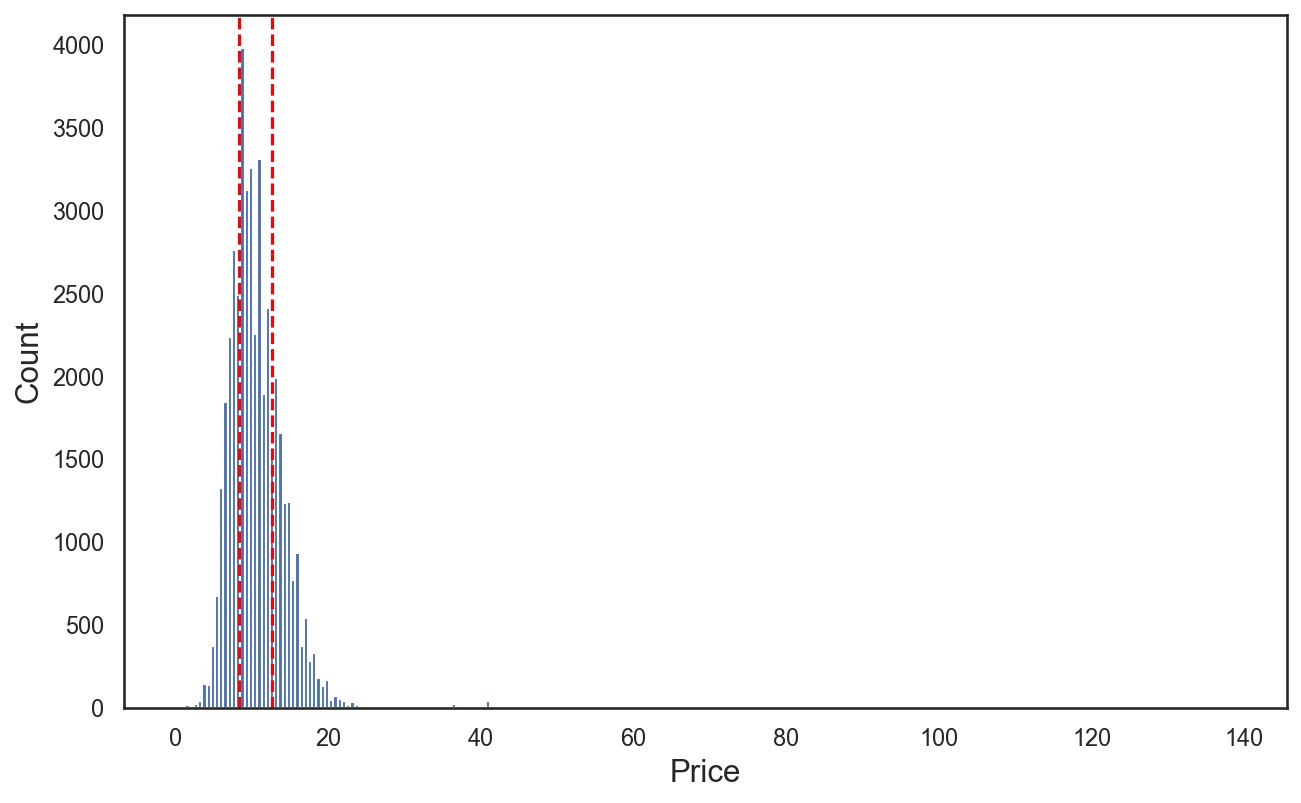

In [115]:
# Calculate the IQR
Q1 = df_sampled["price"].quantile(0.25)
Q3 = df_sampled["price"].quantile(0.75)

# df_sampled['price'].hist()
plt.figure(figsize=(10, 6))
# sns.histplot(data=df_sampled, x="price",
#              label="Price",
#              kde=True,
# #              stat='percent',
# #              bins=500
#             )
plt.hist(df_sampled["price"], bins=250)
plt.axvline(x=Q1, color="red", ls="--", lw=1.5)

plt.axvline(x=Q3, color="red", ls="--", lw=1.5)

plt.xlabel("Price", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

In [116]:
print(df_sampled[df_sampled.price > 50].shape)

IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from df_sampled
df_sampled = df_sampled[(df_sampled["price"] >= lower_bound) & (df_sampled["price"] <= upper_bound)]

(33, 8)


In [117]:
df_sampled.shape

(43373, 8)

In [118]:
# Removed outliers
print("Outlier removal %", (44183 - 43373) * 100 / 44183)

Outlier removal % 1.8332842948645407


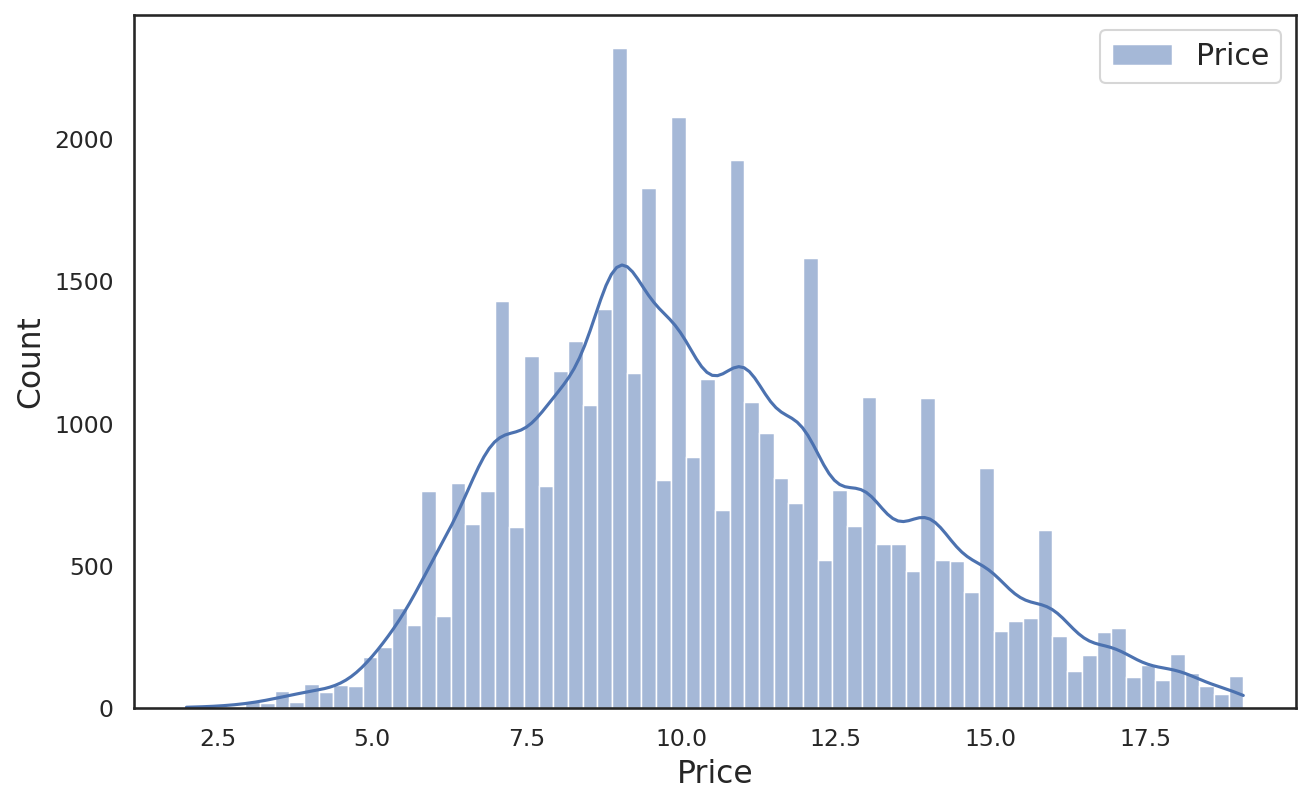

In [271]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_sampled,
    x="price",
    label="Price",
    kde=True,
    #              stat='percent',
    #              bins=500
)


plt.xlabel("Price", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.legend()
plt.show()

In [120]:
# after removing outliers
df_sampled[["price"]].describe().T.style.format("{:.6}")

,count,mean,std,min,25%,50%,75%,max
price,43373.0,10.4971,3.02122,2.0,8.29,10.0,12.49,19.09


## Ingredient List Generation

In [ ]:
%%time

# text cleaning needed
# df_menu_sampled["ingredients"] = df_menu_sampled.description.apply(get_ingredient_tokens).copy()

# kaggle provides 2 cores, hence the task is divided into two batches
df_sampled["ingredients"] = df_sampled.description.progress_apply(get_ingredient_tokens).copy()
df_sampled.drop(["description"], axis=1, inplace=True)

In [ ]:
# Check for ingredients distribution
df_sampled.ingredients.apply(len).value_counts()

#### Ingredients Cleaning

In [ ]:
# dropping rows with 0 ingredients
df_sampled = df_sampled[df_sampled.ingredients.apply(len) > 0].copy()

# convert ingredients to lower case
# might need more cleaning, e.g., remove dash/odd characters from string
df_sampled["ingredients"] = df_sampled.ingredients.map(lambda x: list(map(lambda y: y.lower(), x))).copy()

In [ ]:
# investigate duplicate items

# find the most occurred item from ingredients list
# df_menu_sampled.ingredients.map(lambda x : max(x, key=x.count))

# find ingredients having duplicated items
# df_sampled["ingredients"][df_sampled["ingredients"].map(lambda x :Counter(x).most_common()[0][1]) > 1]

# remove duplicate items
# df_menu_sampled[df_menu_sampled.ingredients.map(lambda x :Counter(x).most_common()[0][1]) > 1].ingredients.map(lambda x: list(set(x)))

df_sampled["ingredients"] = df_sampled["ingredients"].map(lambda x: list(set(x))).copy()
df_sampled["ingredients"] = df_sampled["ingredients"].map(lambda x: list(map(lambda y: y.strip(), x))).copy()

# unescape HTML entities
# https://stackoverflow.com/a/2360639/11105356
df_sampled["ingredients"] = (
    df_sampled["ingredients"]
    .map(lambda x: list(map(lambda y: BeautifulSoup(y, "html").get_text(strip=True), x)))
    .copy()
)
df_sampled["ingredients"] = (
    df_sampled["ingredients"].map(lambda x: list(map(lambda y: html.unescape(y).strip(), x))).copy()
)

In [5]:
df_sampled.drop(columns=["restaurant_id"], axis=1, inplace=True)

In [7]:
df_sampled

,price_range,state_id,city,density,category,price,ingredients
0,$,wi,appleton,1156.0,Salads,12.90,"[3-cheese blend, romaine lettuce, pico de gallo, meat, tomato salsa, tortilla strips, pinto beans]"
1,$,wi,appleton,1156.0,Salads,11.05,"[chile corn salsa, black beans, adobo chicken, romaine lettuce, citrus lime vinaigrette, pico de gallo, tortilla strips]"
2,$$,wi,appleton,1156.0,Salads,7.14,"[cheddar cheese, lettuce, crackers, carrots, iced tomatoes]"
3,$$,wi,appleton,1156.0,Salads,8.24,"[diced eggs, diced ham, cheddar cheese, lettuce, diced tomatoes, crackers, bacon, carrots]"
4,$$,wi,appleton,1156.0,Salads,8.24,"[cheddar cheese, lettuce, fajita chicken, diced tomatoes, crackers, carrots]"
...,...,...,...,...,...,...,...
43216,$$,tx,houston,1399.0,Sandwiches,11.89,"[mayo, tomato basil soup, crimini mushrooms, grain, zucchini, basil pesto, lemon, mozzarella cheese, spinach, mixed greens]"
43217,$$,tx,houston,1399.0,Sandwiches,14.27,"[organic mixed greens, tomato basil soup, horseradish sauce, onions, tomato, lemon, parmesan-crusted sourdough, beef, arugula, horseradish havarti]"
43218,$$,tx,houston,1399.0,Sandwiches,12.60,"[tomato basil soup, tomato, lemon, dijonnaise, gruyere cheese, ham, artisan brioche, mixed greens]"
43219,$$,tx,houston,1399.0,Sandwiches,11.89,"[peppadew peppers, avocado, organic mixed greens, onions, red onion, tomato basil soup, tomato, brioche bun, lemon, mushrooms, brown rice, dijonnaise, patty, carrots]"


## Cost of Index

In [8]:
df_cost_index = pd.read_csv("dataset/cost_of_living_index.csv")

In [49]:
df_cost_index.head()

,state_id,city,city_index,ny_index,cost_of_living_index
0,tx,san antonio,89.8,168.6,53.26
1,tx,austin,129.4,168.6,76.75
2,wi,milwaukee,84.7,168.6,50.24
3,va,richmond,96.1,168.6,57.00
4,tx,fort worth,100.2,168.6,59.43


In [10]:
df_sampled = pd.merge(
    df_sampled, df_cost_index[["state_id", "city", "cost_of_living_index"]], how="left", on=["city", "state_id"]
).copy()

In [11]:
df_sampled[df_sampled.cost_of_living_index.isna()].state_id.value_counts()

ut    511
Name: state_id, dtype: int64

In [12]:
df_sampled[df_sampled.cost_of_living_index.isna()].city.value_counts()

layton    511
Name: city, dtype: int64

In [13]:
# layton city does not have mapped cost of living index value
df_sampled = df_sampled[df_sampled.city != "layton"].copy()

In [14]:
df_sampled.reset_index(drop=True, inplace=True)

In [50]:
df_sampled.head()

,price_range,state_id,city,density,category,price,ingredients,cost_of_living_index,cluster
0,cheap,wi,appleton,1156.0,Salads,12.90,"[3-cheese blend, romaine lettuce, pico de gallo, meat, tomato salsa, tortilla strips, pinto beans]",49.94,0
1,cheap,wi,appleton,1156.0,Salads,11.05,"[chile corn salsa, black beans, adobo chicken, romaine lettuce, citrus lime vinaigrette, pico de gallo, tortilla strips]",49.94,0
2,moderate,wi,appleton,1156.0,Salads,7.14,"[cheddar cheese, lettuce, crackers, carrots, iced tomatoes]",49.94,0
3,moderate,wi,appleton,1156.0,Salads,8.24,"[diced eggs, diced ham, cheddar cheese, lettuce, diced tomatoes, crackers, bacon, carrots]",49.94,0
4,moderate,wi,appleton,1156.0,Salads,8.24,"[cheddar cheese, lettuce, fajita chicken, diced tomatoes, crackers, carrots]",49.94,0


In [16]:
df_sampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42710 entries, 0 to 42709
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price_range           42710 non-null  object 
 1   state_id              42710 non-null  object 
 2   city                  42710 non-null  object 
 3   density               42710 non-null  float64
 4   category              42710 non-null  object 
 5   price                 42710 non-null  float64
 6   ingredients           42710 non-null  object 
 7   cost_of_living_index  42710 non-null  float64
dtypes: float64(3), object(5)
memory usage: 2.6+ MB


In [142]:
# Total datapoints removed
print(
    f"Datapoints total removed: count: {43373 - 42710}, {round((44183 - 42710) * 100 / 44183, 3)}%",
)

Datapoints total removed: count: 663, 3.334%


In [315]:
# pearson correlation
df_sampled.corr()

,density,price,cost_of_living_index
density,1.000000,0.097751,0.547760
price,0.097751,1.000000,0.095873
cost_of_living_index,0.547760,0.095873,1.000000


# Feature Analysis

## Price Range

In [321]:
# price range distribution
df_sampled.price_range.value_counts()

$      38288
$$      4380
$$$       42
Name: price_range, dtype: int64

In [17]:
# price range conversion
df_sampled["price_range"] = (
    df_sampled["price_range"]
    .apply(lambda x: "cheap" if x == "$" else ("moderate" if x == "$$" else "expensive"))
    .copy()
)

In [387]:
df_sampled.groupby(["price_range"]).price.describe().style.format("{:.6}")

,count,mean,std,min,25%,50%,75%,max
price_range,,,,,,,,
cheap,38288.0,10.4067,2.98237,2.0,8.25,9.99,12.29,19.09
expensive,42.0,12.3848,3.74388,5.5,9.2475,12.99,15.0,19.0
moderate,4380.0,11.4317,3.20276,2.59,9.1975,11.7,13.5,19.0


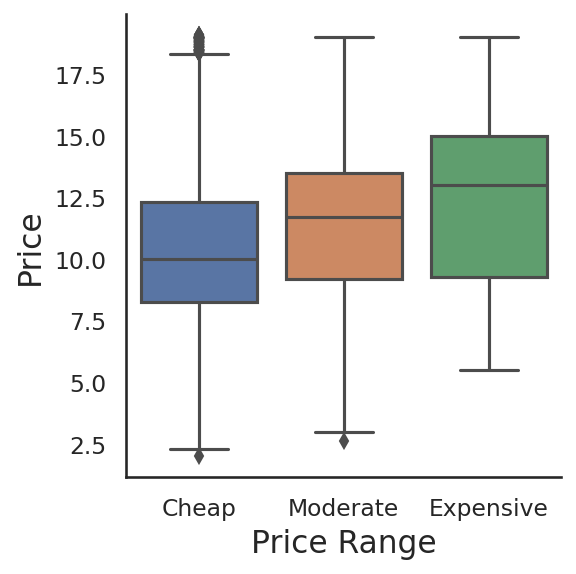

In [410]:
# df_sampled.price_range.map({'$':'A', '$$':'AA', '$$$':'AAA'})
# sns.catplot()
g = sns.catplot(
    data=df_sampled.sort_values(by=["price_range"], key=lambda x: x.map(x.value_counts()), ascending=False),
    x="price_range",
    y="price",
    #     hue="weekend",
    kind="box",
    dodge=False,
    height=4,
)
g.set_axis_labels("Price Range", "Price")
g.set_xticklabels(["Cheap", "Moderate", "Expensive"])
plt.show()

## Category

In [385]:
df_sampled.groupby(["category"]).price.describe().style.format("{:.6}")

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Salads,12526.0,10.1026,2.72214,2.29,8.49,9.59,11.5,19.0
Sandwiches,23430.0,10.7304,3.37034,2.0,7.79,10.53,13.29,19.09
Wraps,6754.0,10.5248,2.04166,4.99,8.99,10.19,11.69,18.95


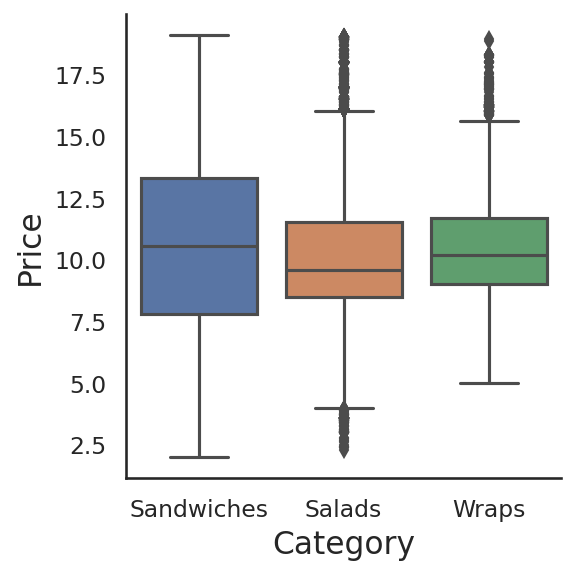

In [408]:
g = sns.catplot(
    data=df_sampled.sort_values(by=["category"], key=lambda x: x.map(x.value_counts()), ascending=False),
    x="category",
    y="price",
    #     hue="weekend",
    kind="box",
    dodge=False,
    height=4,
)
g.set_axis_labels("Category", "Price")
plt.show()

## State

In [54]:
df_sampled["state_id"].replace(states_name_dict, inplace=True)
df_sampled.groupby(["state_id"]).price.describe().style.format("{:.6}")

,count,mean,std,min,25%,50%,75%,max
state_id,,,,,,,,
Texas,12724.0,9.84273,2.88732,2.29,7.76,9.43,11.89,19.06
Utah,3476.0,9.89298,2.71368,2.39,7.79,9.59,11.49,19.09
Virginia,9552.0,10.4659,2.92234,2.59,8.39,9.99,12.46,19.07
Washington,9396.0,11.7189,3.0296,2.0,9.48,11.29,13.9725,19.0
Wisconsin,7562.0,10.491,3.04523,2.95,8.29,9.99,12.48,19.09


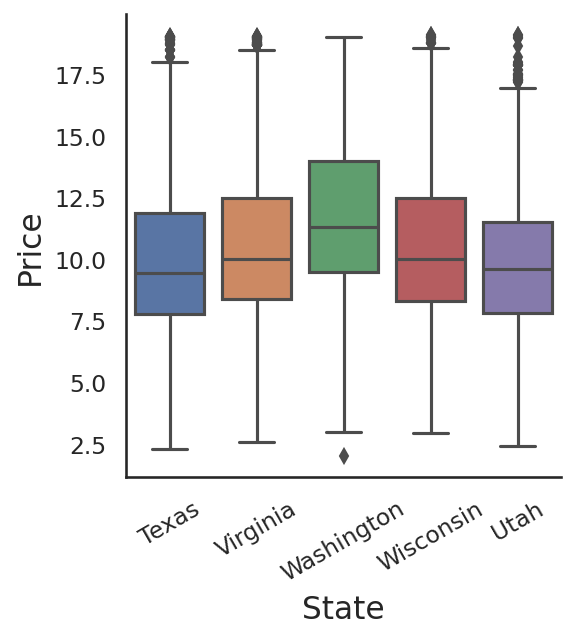

In [409]:
g = sns.catplot(
    data=df_sampled.sort_values(by=["state_id"], key=lambda x: x.map(x.value_counts()), ascending=False),
    x="state_id",
    y="price",
    #     hue="weekend",
    kind="box",
    dodge=False,
    height=4,
)
g.set_axis_labels("State", "Price")
g.set_xticklabels(rotation=30)
plt.show()

## K-means++

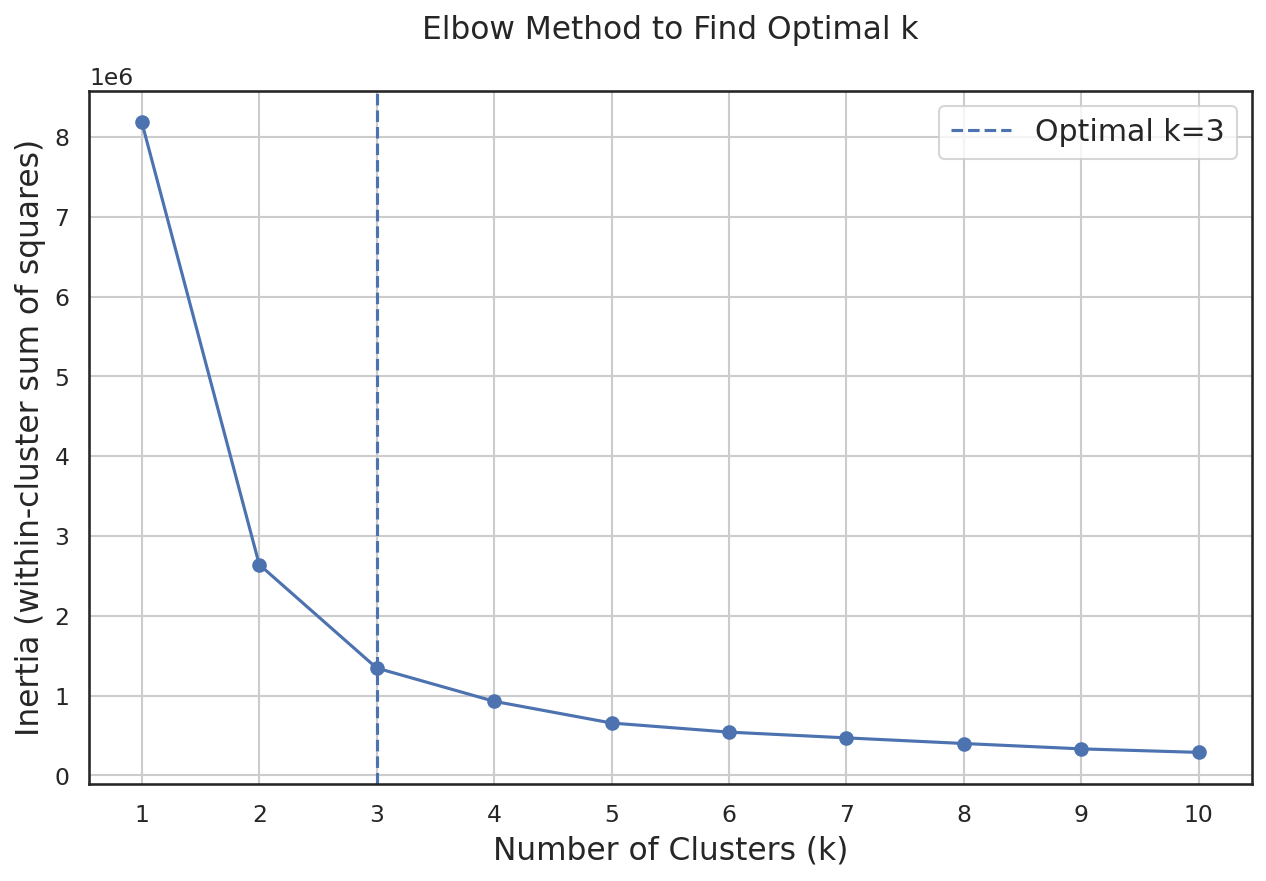

In [41]:
# import pandas as pd
# import numpy as np
from sklearn.cluster import KMeans

# import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with 'cost_of_living', 'price', and 'city_name' columns
# Extracting features for clustering
X = df_sampled[["cost_of_living_index", "price"]].values

# Determining the optimal number of clusters using the elbow method
inertia = []
max_clusters = 10  # You can change this based on your data
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=SEED)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), inertia, marker="o")
plt.xticks(range(1, max_clusters + 1))
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (within-cluster sum of squares)")
plt.title("Elbow Method to Find Optimal k")
plt.grid(True)
plt.axvline(x=3, linestyle="--", label="Optimal k=3")  # from the plot x=3 optimal value can be figured out
# plt.text(3,4,'blah',rotation=0)
plt.legend()
plt.show()

### Analysis

In [76]:
# df_sampled['cluster'].value_counts()
df_sampled.groupby("cluster")["city"].nunique()

cluster
0    13
1     3
2     8
Name: city, dtype: int64

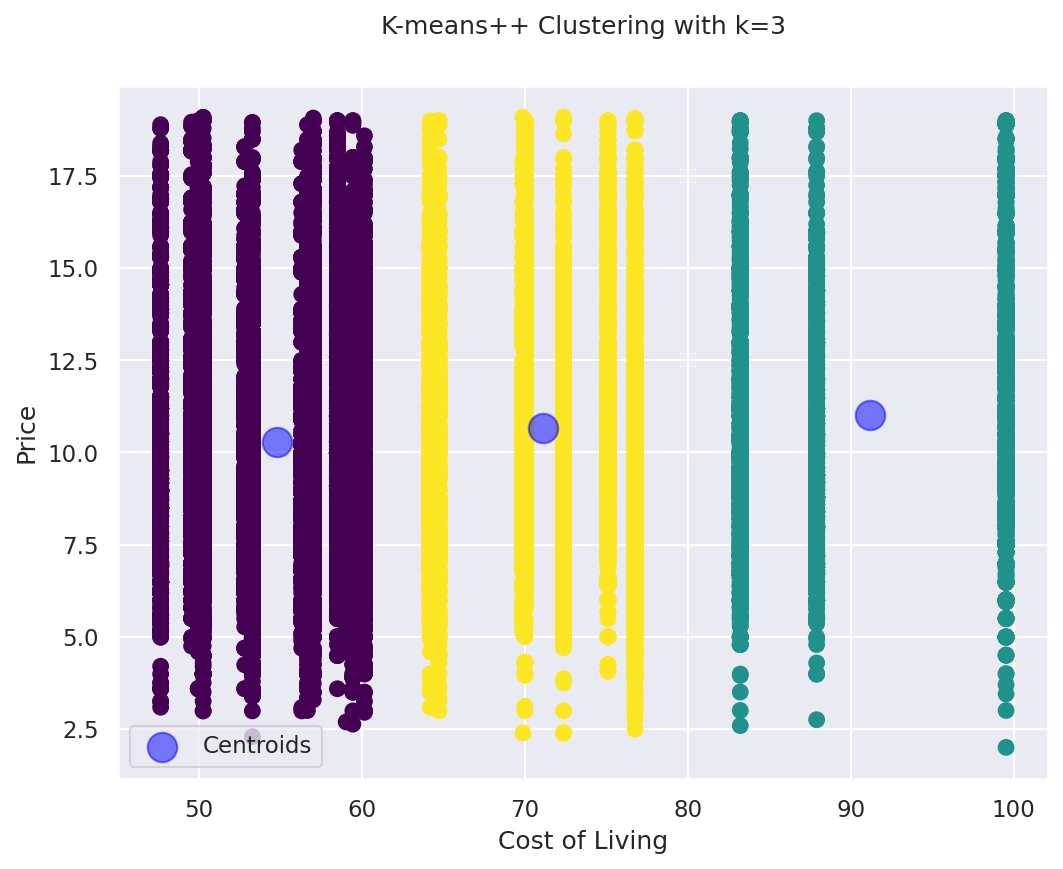

In [65]:
# From the elbow curve, determine the optimal number of clusters 'k'
# You can select the value of k where the elbow occurs and re-run KMeans with that value

# Performing K-means++ clustering with the optimal 'k' value
k_optimal = 3  # Change this based on the elbow curve or your own decision
kmeans = KMeans(n_clusters=k_optimal, init="k-means++", random_state=SEED)
df_sampled["cluster"] = kmeans.fit_predict(X)  # y_kmeans

# Visualization of clusters
plt.figure(figsize=(8, 6))
# sns.set_theme()
plt.scatter(X[:, 0], X[:, 1], c=df_sampled["cluster"], s=50, cmap="viridis")
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    s=200,
    c="blue",
    #             marker='X',
    label="Centroids",
    alpha=0.5,
)

plt.xlabel("Cost of Living")
plt.ylabel("Price")
plt.title(f"K-means++ Clustering with k={k_optimal}")
plt.legend()
plt.grid(True)
plt.show()

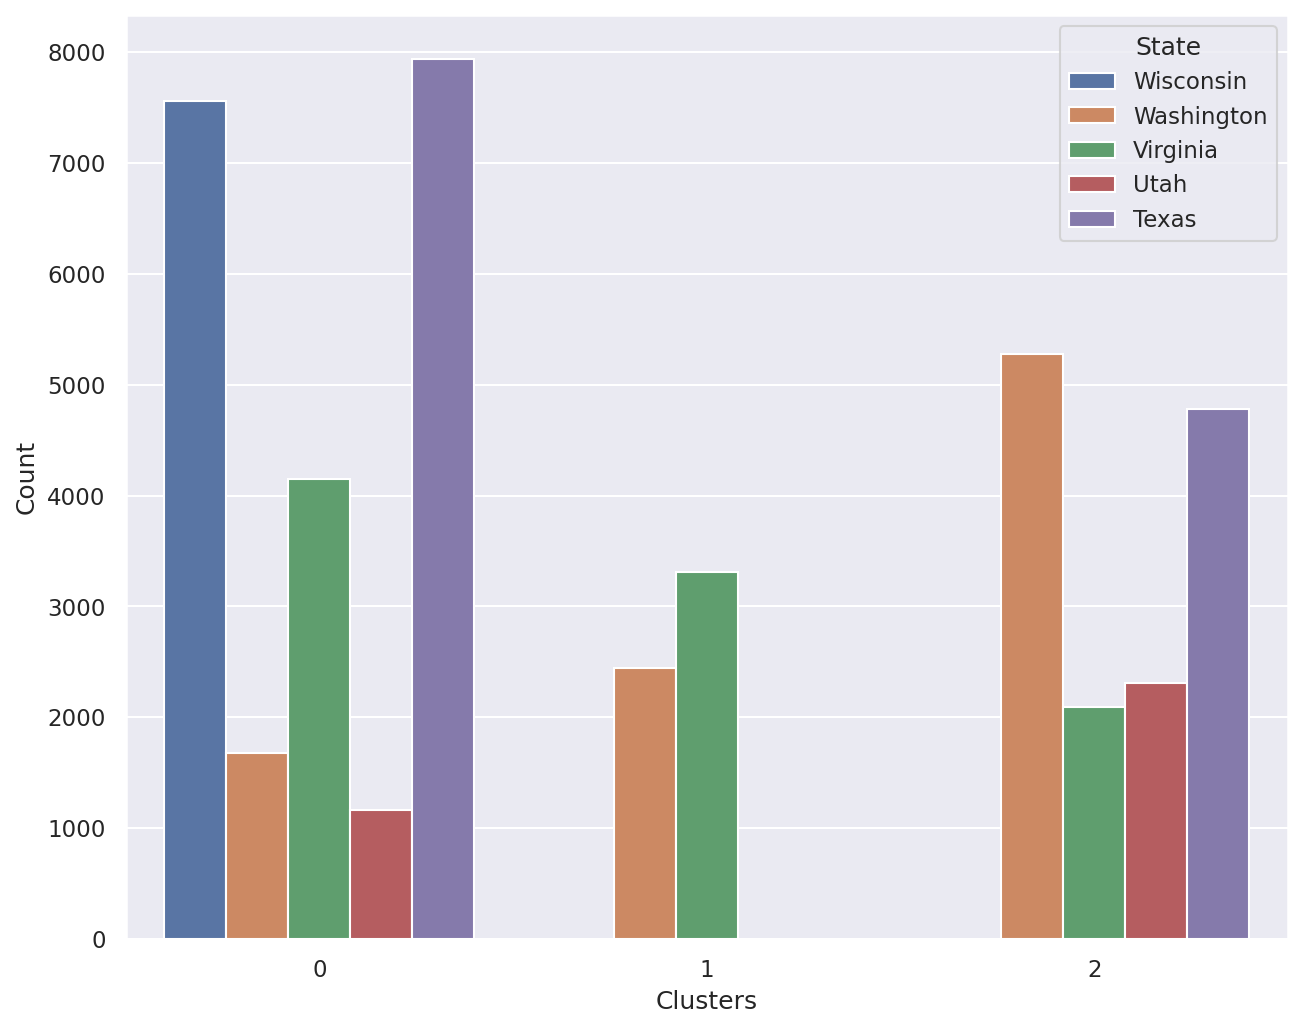

In [59]:
sns.countplot(x="cluster", hue="state_id", data=df_sampled)
plt.legend(title="State")
plt.xlabel("Clusters")
plt.ylabel("Count")
plt.show()

In [ ]:
### dump to csv

# df_sampled.to_csv("sampled-final-data.csv", index=False)

# if dumped, then read csv back
# df_sampled = pd.read_csv("dataset/sampled-final-data.csv.csv")
# df_sampled["ingredients"] = df_sampled["ingredients"].apply(ast.literal_eval)

# BERT Embedding

In [ ]:
# Load the BERT tokenizer and model
tokenizer_emb = BertTokenizer.from_pretrained("bert-base-uncased")
model_emb = BertModel.from_pretrained("bert-base-uncased").to(device)

# Example list of text
text_list = [
    [
        "chicken breast",
        "lettuce",
    ],
    ["hummus", "tahini sauce", "lettuce", "tomatoes", "pickles", "fries"],
]

# Tokenize the text and convert it to input IDs
encoded_inputs = tokenizer_emb(text_list[0], padding=True, truncation=True, return_tensors="pt").to(device)


# Get the input IDs and attention mask
input_ids = encoded_inputs["input_ids"]
print(encoded_inputs, input_ids)
attention_mask = encoded_inputs["attention_mask"]

# Pass the input IDs and attention mask through the BERT model to get the embeddings
with torch.no_grad():
    outputs = model_emb(input_ids, attention_mask=attention_mask)

# Extract the embeddings from the BERT model's output
# embeddings = outputs['last_hidden_state']

# Print the embeddings
print(outputs.last_hidden_state)

embeddings = outputs.last_hidden_state
word_embedding = embeddings.squeeze(0)  # Remove the batch dimension if present
print(word_embedding)
word_embedding = word_embedding[
    encoded_inputs.input_ids.squeeze(0) == tokenizer_emb.convert_tokens_to_ids(text_list[1][3])
]
print(word_embedding)


# concat embeddings
# https://datascience.stackexchange.com/a/107080/98646
# https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#word-vectors

# # Stores the token vectors, with shape [7 x 3,072]
# token_vecs_cat = []

# # `token_embeddings` is a [7 x 5 x 768] tensor.

In [77]:
# https://stackoverflow.com/a/64714245/11105356

from transformers import pipeline

checkpoint = "bert-base-uncased"  # distilroberta-base bert-base-uncased facebook/bart-base facebook/bart-large
feature_extractor = pipeline("feature-extraction", framework="pt", model=checkpoint, tokenizer=checkpoint, device=0)

# text = ['hummus', 'tahini sauce', 'lettuce', 'tomatoes', 'pickles', 'fries']

# Reducing along the first dimension to get a 768 dimensional array
# feature_vectors = feature_extractor(text, return_tensors = "pt", device=0)

# np.array([vec[0].numpy().mean(axis=0) for vec in feature_vectors]).mean(axis=0)

# feature_vectors[0].mean(axis=1)
# torch.mean(feature_vectors[0], axis=1)


def get_embedding(tokens):
    feature_vectors = feature_extractor(tokens, return_tensors="pt", device=0)
    return np.array([vec[0].numpy().mean(axis=0) for vec in feature_vectors]).mean(axis=0)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [79]:
# df_sampled.head()['ingredients']

df_sampled["ingredient_embedding"] = df_sampled.ingredients.progress_apply(get_embedding).copy()

  0%|          | 0/42710 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [82]:
%%time

# pd.concat([df_sampled.drop(columns=['ingredient_embedding']), df_sampled.ingredient_embedding.apply(pd.Series)], axis=1).copy()
df_embed = pd.concat(
    [df_sampled.drop(columns=["ingredient_embedding"]), df_sampled.ingredient_embedding.apply(pd.Series)], axis=1
).copy()
df_embed.to_csv("recipe-BERT-embedding.csv", index=False)

CPU times: user 50.7 s, sys: 871 ms, total: 51.5 s
Wall time: 51.6 s


In [85]:
df_embed.drop(["ingredients"], axis=1, inplace=True)
df_embed.reset_index(drop=True, inplace=True)

In [92]:
df_embed.head()

,price_range,state_id,city,density,category,price,cost_of_living_index,cluster,0,1,...,758,759,760,761,762,763,764,765,766,767
0,cheap,Wisconsin,appleton,1156.0,Salads,12.90,49.94,0,0.159460,-0.036868,...,0.026322,-0.005716,-0.127598,-0.114510,0.164736,-0.207848,-0.055077,-0.026595,-0.062297,-0.134116
1,cheap,Wisconsin,appleton,1156.0,Salads,11.05,49.94,0,0.113225,0.006558,...,-0.057887,-0.022599,-0.188540,-0.084586,0.132903,-0.170029,-0.161381,-0.070256,-0.127915,-0.146472
2,moderate,Wisconsin,appleton,1156.0,Salads,7.14,49.94,0,0.065384,0.080364,...,-0.091790,-0.049718,-0.155244,-0.019232,0.302928,-0.194753,-0.128962,-0.038832,-0.074880,-0.319695
3,moderate,Wisconsin,appleton,1156.0,Salads,8.24,49.94,0,0.155822,0.099332,...,0.042928,-0.012281,-0.093055,0.006777,0.259156,-0.108748,-0.146209,-0.076722,-0.032052,-0.221146
4,moderate,Wisconsin,appleton,1156.0,Salads,8.24,49.94,0,0.089353,-0.014853,...,-0.040314,-0.002007,-0.110360,0.011852,0.206243,-0.108016,-0.145544,-0.101227,-0.052243,-0.223844
